In [51]:
%matplotlib inline

In [11]:
import pymc3 as pm
import numpy as np
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt

In [29]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [30]:
data

array([1, 0, 0, 0])

In [31]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 2549.05draws/s]


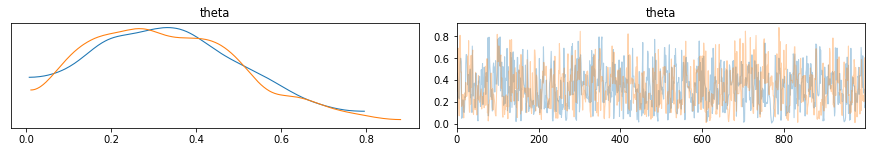

In [32]:
with our_first_model:
    az.plot_trace(trace)
    res = az.summary(trace)

In [33]:
res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.333,0.176,0.02,0.635,0.006,0.004,851.0,851.0,817.0,834.0,1.0


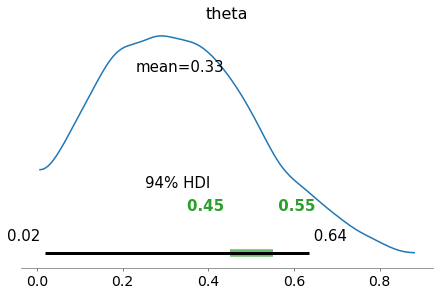

In [36]:
with our_first_model:
    az.plot_posterior(trace, rope=[0.45,0.55])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:01<00:00, 1806.53draws/s]
/home/carl/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f12322820>,
      dtype=object)

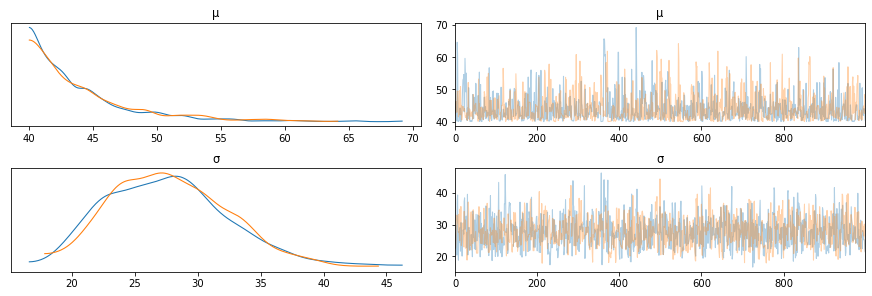

In [38]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

/home/carl/miniconda3/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


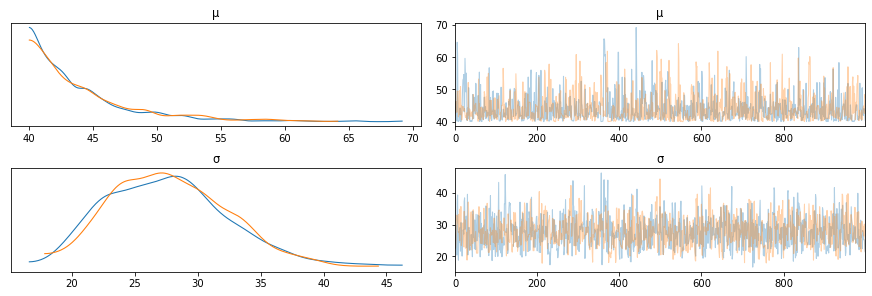

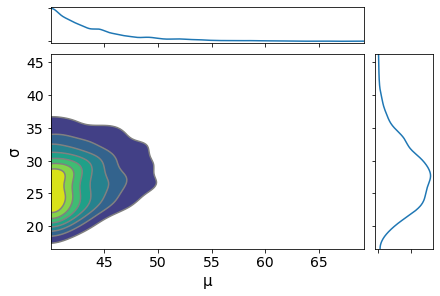

In [40]:
with model_g:
    az.plot_trace(trace_g)
    az.plot_joint(trace_g, kind='kde', fill_last=False)
plt.show()

In [42]:
trace_g['σ']

array([22.28792568, 26.64281735, 26.04688299, ..., 30.11668141,
       28.97145165, 21.55746387])

# Group comparison

In [55]:
import pandas as pd
import seaborn as sns
sns.set()

In [45]:
tips = pd.read_csv('data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


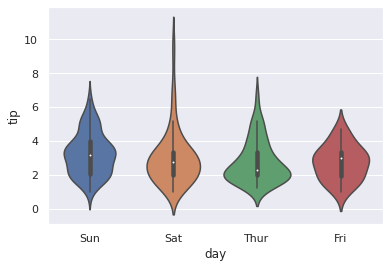

In [57]:
sns.violinplot(x='day', y='tip', data=tips)

In [61]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))
groups

4

In [62]:
idx

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0], dtype=int8)

In [63]:
with pm.Model() as comparison_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:07<00:00, 1399.72draws/s]


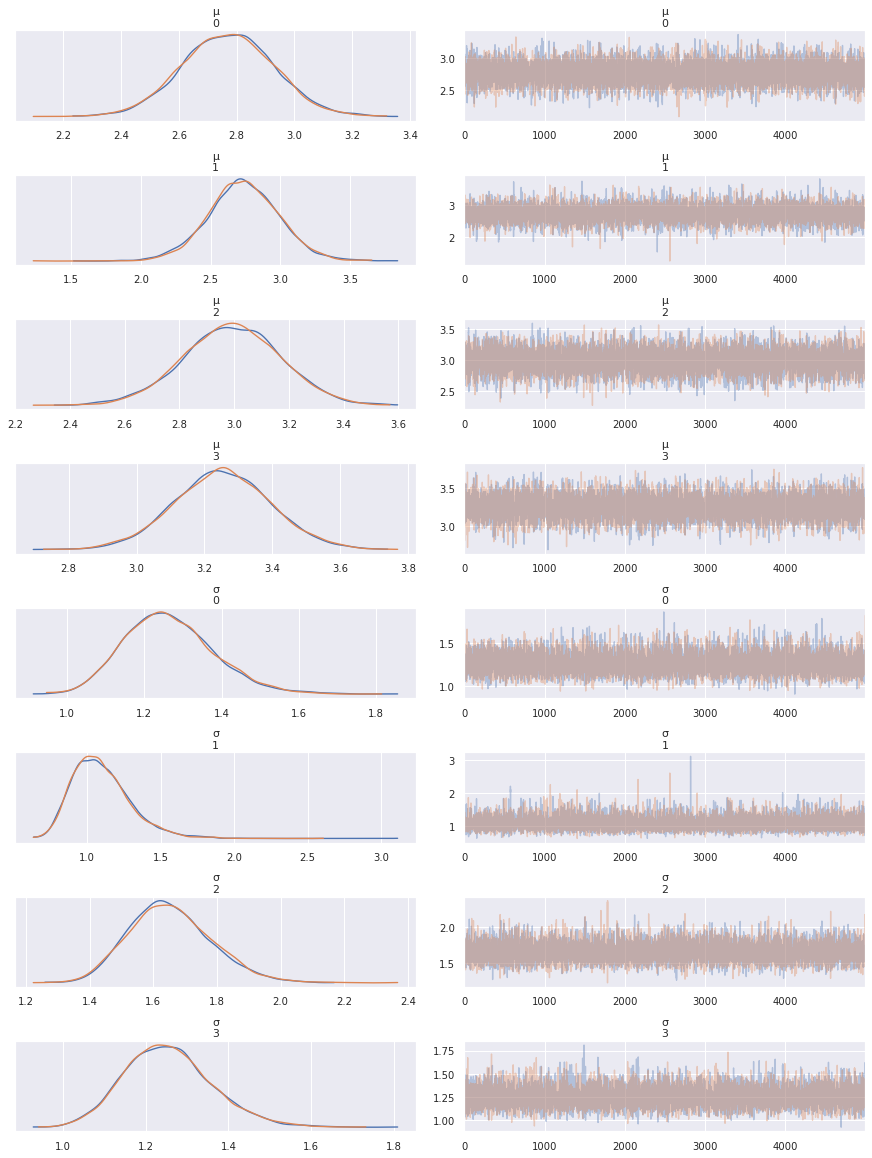

In [64]:
with comparison_groups:
    az.plot_trace(trace_cg)

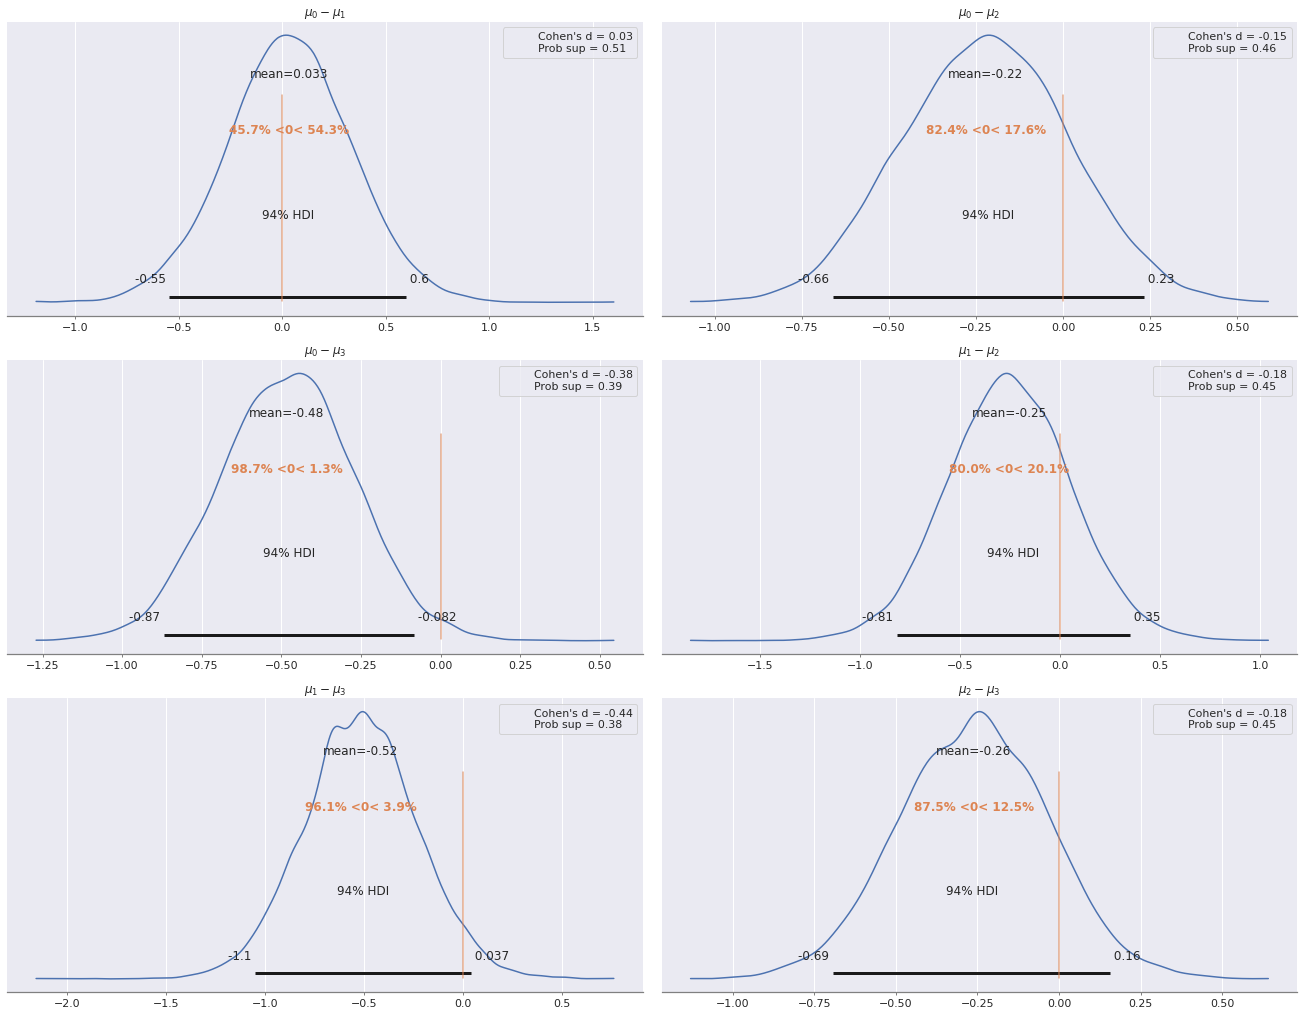

In [72]:
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(18,14), constrained_layout=True)
comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0,1)]
for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2)/2)).mean()
    ps = dist.cdf(d_cohen/np.sqrt(2))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}",alpha=0)
    ax[k, l].legend()

# Hierarchical models